# LSTM MODEL:-
RNN Model has short memory, so older data could be erased. But LSTM (Long Short-Term Memory) Model has long memory
So LSTM is advanced version of RNN which works in the same format

In [1]:
# In this notebook we will create LSTM Model
# Step 1:- We will load the saved sequences
import numpy as np
data = np.load("../data/tesla_sequences.npz")

# Step 2:- To check if all the sequences are saved and loaded or not
data.files

['X_train_1d',
 'y_train_1d',
 'X_test_1d',
 'y_test_1d',
 'X_train_5d',
 'y_train_5d',
 'X_test_5d',
 'y_test_5d',
 'X_train_10d',
 'y_train_10d',
 'X_test_10d',
 'y_test_10d']

# Building the Model for 1-Day Prediction

In [2]:
# Step 1:- Loading the day 1 prediction sequences
X_train_one = data["X_train_1d"]
y_train_one = data["y_train_1d"]
X_test_one  = data["X_test_1d"]
y_test_one  = data["y_test_1d"]

print(X_train_one.shape, y_train_one.shape) 

# Meaning of X_train shape → (1872, 60, 1). 1872 → Number of training samples. 60 → Number of past days used (WINDOW_SIZE)
# 1 → Number of features (Adj Close price)


# Meaning of y_train shape → (1872, 1, 1). 1872 → Number of training samples. 1 → Forecast horizon (1-day prediction)
# 1 → One output feature (Adj Close)

(1872, 60, 1) (1872, 1, 1)


In [3]:
# Step 2:- Importing Required Libraries
from tensorflow.keras.models import Sequential  # Sequential Library builds Neural Network layer by layer in order
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout  # LSTM is used for sequence learning
# LSTM Library develops the main recurrent layer which learns from long-term sequences
# Dense Library develops a fully connected layer used for prediction
# Dropout Library disables few neurons to prevent overfitting
from tensorflow.keras.optimizers import Adam  # Adam optimizer adjusts the weights efficiently during training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# EarlyStopping stops training when there is no improvement
# ModelCheckpoint saves the best model automatically
from scikeras.wrappers import KerasRegressor
# KerasRegressor is used to wrap the LSTM model so it can work with GridSearchCV
from sklearn.model_selection import GridSearchCV
# GridSearchCV is used to try different hyperparameter combinations


# -------------------------------
# Step 3:- Building The Simple RNN Model
# -------------------------------

def build_simple_lstm_one(units, dropout_rate, learning_rate):

    model_lstm_one = Sequential() # We create an empty neural network model, in which we add layers later on


    # -------------------------------
    # Step 4:- Adding Layers to the Neural Network Model
    # -------------------------------

    model_lstm_one.add(Input(shape=(X_train_one.shape[1], X_train_one.shape[2]))) # Here we add the input shape
    # We already got the output for X_train.shape and y_train.shape = (1872, 60, 1) (1872, 1, 1)
    # So X_train[1] means 60 (No of steps or days) and X_train[2] means 1 (No of features or 1 stock price)

    model_lstm_one.add(LSTM(
        units=units, # The model will have memory cells to learn pattern
        activation='tanh' # Helps the model learn non-linear patterns like trends from past prices
    ))


    model_lstm_one.add(Dropout(dropout_rate)) # Here we add the dropout layer which disables neurons to avoid overfitting

    model_lstm_one.add(Dense(y_train_one.shape[1])) # This is the final layer which shows prediction
    # y_train[1] means 1 (output like 1-day, 5-days or 10-days)



    # -------------------------------
    # Step 5:- Compiling The Model
    # -------------------------------
    model_lstm_one.compile(
        optimizer=Adam(learning_rate=learning_rate), # Controls how fast the Model Learns
        loss='mean_squared_error' # Measures the prediction error 
    )
    return model_lstm_one


# -------------------------------
# Step 6:- Wrapping the model in Keras Regressor
# -------------------------------
lstm_regressor_one = KerasRegressor(
    model=build_simple_lstm_one,   
    epochs=20,
    batch_size=32,
    verbose=0
)

# -------------------------------
# Step 7:- Create Grid Parameters
# -------------------------------
param_grid = {
    'model__units': [32, 50, 64],
    'model__dropout_rate': [0.2, 0.3],
    'model__learning_rate': [0.001, 0.0005]
}



# -------------------------------
# Step 8:- Apply Grid Search
# -------------------------------
grid_search_one = GridSearchCV(
    estimator=lstm_regressor_one,
    param_grid=param_grid,
    cv=3
)

# This step is necessary because Grid expects 2-D object, but y_train is 3-D object
# So here we convert y_train from 2-D to 3-D object
y_train_one = y_train_one.reshape(y_train_one.shape[0], y_train_one.shape[1])


grid_search_one.fit(X_train_one, y_train_one)


print("Best Hyperparameters for SimpleRNN:")
print(grid_search_one.best_params_)

print("Best MSE Score:")
print(-grid_search_one.best_score_)

# -------------------------------
# Step 9:- Return the Best Parameters
# -------------------------------
best_params_one = grid_search_one.best_params_


# -------------------------------
# Step 10:- Create the Final Model
# -------------------------------
final_lstm_model_one = build_simple_lstm_one(
    units=best_params_one['model__units'],
    dropout_rate=best_params_one['model__dropout_rate'],
    learning_rate=best_params_one['model__learning_rate']
)

final_lstm_model_one.summary() # This will print the model structure


# -------------------------------
# Step 11:- Creating Callbacks 
# -------------------------------
# EarlyStopping will stop the training if there is no improve in validation loss after 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# -------------------------------
# Step 12:- Saving the Best Model
# -------------------------------
model_checkpoint = ModelCheckpoint(
    filepath="../models/simple_lstm_best_model_one.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)



# -------------------------------
# Step 13:- Training The Model
# -------------------------------
history_lstm_one = final_lstm_model_one.fit(
    X_train_one, y_train_one,
    validation_data=(X_test_one, y_test_one),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=0
)


print('Trainig of LSTM Model for 1-Day is completed')

2026-01-12 00:19:38.258679: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-12 00:19:58.418747: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Best Hyperparameters for SimpleRNN:
{'model__dropout_rate': 0.2, 'model__learning_rate': 0.001, 'model__units': 50}
Best MSE Score:
0.057295826878440516


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Trainig of LSTM Model for 1-Day is completed


# LSTM Model Summary – Explanation

This LSTM model is designed to predict the next day’s Tesla stock closing price using the past 60 days of historical data. Compared to SimpleRNN, LSTM is more powerful in learning long-term patterns.

LSTM Layer (50 units)
This is the main learning layer of the model.
LSTM can remember important information and forget irrelevant data using internal gates (input, forget, and output gates).
This helps it handle long-term dependencies in stock price data.
The layer has 10,400 trainable parameters, which is higher than SimpleRNN because LSTM uses multiple gates.

Dropout Layer (20%)
This layer reduces overfitting by randomly turning off some neurons during training.
It helps the model generalize better on unseen data.

Dense Output Layer (1 neuron)
This layer outputs a single predicted value, which is the next day’s closing price.
It has 51 parameters.

Total Parameters: 10,451
The LSTM model has significantly more parameters than SimpleRNN, making it more expressive and powerful, but also more computationally expensive.

# Build the Model for 5-Day Prediction

In [4]:
# Step 1:- Loading the day 5 prediction sequences
X_train_five = data["X_train_5d"]
y_train_five = data["y_train_5d"]
X_test_five  = data["X_test_5d"]
y_test_five  = data["y_test_5d"]

print(X_train_five.shape, y_train_five.shape) 

(1868, 60, 1) (1868, 5, 1)


In [5]:
# -------------------------------
# Step 2:- Building The Simple LSTM Model
# -------------------------------

def build_simple_lstm_five(units, dropout_rate, learning_rate):

    model_lstm_five = Sequential() # We create an empty neural network model, in which we add layers later on


    # -------------------------------
    # Step 3:- Adding Layers to the Neural Network Model
    # -------------------------------

    model_lstm_five.add(Input(shape=(X_train_five.shape[1], X_train_five.shape[2]))) # Here we add the input shape
    # We already got the output for X_train.shape and y_train.shape = (1872, 60, 1) (1872, 1, 1)
    # So X_train[1] means 60 (No of steps or days) and X_train[2] means 1 (No of features or 1 stock price)

    model_lstm_five.add(LSTM(
        units=units, # The model will have memory cells to learn pattern
        activation='tanh' # Helps the model learn non-linear patterns like trends from past prices
    ))


    model_lstm_five.add(Dropout(dropout_rate)) # Here we add the dropout layer which disables neurons to avoid overfitting

    model_lstm_five.add(Dense(y_train_five.shape[1])) # This is the final layer which shows prediction
    # y_train[1] means 1 (output like 1-day, 5-days or 10-days)



    # -------------------------------
    # Step 4:- Compiling The Model
    # -------------------------------
    model_lstm_five.compile(
        optimizer=Adam(learning_rate=learning_rate), # Controls how fast the Model Learns
        loss='mean_squared_error' # Measures the prediction error 
    )
    return model_lstm_five


# -------------------------------
# Step 5:- Wrapping the model in Keras Regressor
# -------------------------------
lstm_regressor_five = KerasRegressor(
    model=build_simple_lstm_five,   
    epochs=20,
    batch_size=32,
    verbose=0
)



# -------------------------------
# Step 6:- Apply Grid Search
# -------------------------------
grid_search_five = GridSearchCV(
    estimator=lstm_regressor_five,
    param_grid=param_grid,
    cv=3
)

# This step is necessary because Grid expects 2-D object, but y_train is 3-D object
# So here we convert y_train from 2-D to 3-D object
y_train_five = y_train_five.reshape(y_train_five.shape[0], y_train_five.shape[1])


grid_search_five.fit(X_train_five, y_train_five)


print("Best Hyperparameters for SimpleRNN:")
print(grid_search_five.best_params_)

print("Best MSE Score:")
print(-grid_search_five.best_score_)

# -------------------------------
# Step 7:- Return the Best Parameters
# -------------------------------
best_params_five = grid_search_five.best_params_


# -------------------------------
# Step 8:- Create the Final Model
# -------------------------------
final_lstm_model_five = build_simple_lstm_five(
    units=best_params_five['model__units'],
    dropout_rate=best_params_five['model__dropout_rate'],
    learning_rate=best_params_five['model__learning_rate']
)

final_lstm_model_five.summary() # This will print the model structure


# -------------------------------
# Step 9:- Saving the Best Model
# -------------------------------
model_checkpoint = ModelCheckpoint(
    filepath="../models/simple_lstm_best_model_five.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)



# -------------------------------
# Step 10:- Training The Model
# -------------------------------
history_lstm_five = final_lstm_model_five.fit(
    X_train_five, y_train_five,
    validation_data=(X_test_five, y_test_five),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=0
)


print('Trainig of LSTM Model for 5-Day is completed')

Best Hyperparameters for SimpleRNN:
{'model__dropout_rate': 0.2, 'model__learning_rate': 0.001, 'model__units': 64}
Best MSE Score:
1.234031034055202


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_75 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,221 (67.27 KB)

 Trainable params: 17,221 (67.27 KB)

 Non-trainable params: 0 (0.00 B)

Trainig of LSTM Model for 5-Day is completed


# LSTM Model Summary – Explanation

This LSTM model is designed to predict the next day’s Tesla stock closing price using the past 60 days of historical data. Compared to SimpleRNN, LSTM is more powerful in learning long-term patterns.

LSTM Layer (50 units)
This is the main learning layer of the model.
LSTM can remember important information and forget irrelevant data using internal gates (input, forget, and output gates).
This helps it handle long-term dependencies in stock price data.
The layer has 10,400 trainable parameters, which is higher than SimpleRNN because LSTM uses multiple gates.

Dropout Layer (20%)
This layer reduces overfitting by randomly turning off some neurons during training.
It helps the model generalize better on unseen data.

Dense Output Layer (1 neuron)
This layer outputs a single predicted value, which is the next day’s closing price.
It has 51 parameters.

Total Parameters: 10,451
The LSTM model has significantly more parameters than SimpleRNN, making it more expressive and powerful, but also more computationally expensive.

# Build the Model for 10-Day Prediction

In [6]:
# Step 1:- Loading the day 10 prediction sequences
X_train_ten = data["X_train_10d"]
y_train_ten = data["y_train_10d"]
X_test_ten  = data["X_test_10d"]
y_test_ten  = data["y_test_10d"]

print(X_train_ten.shape, y_train_ten.shape) 

(1863, 60, 1) (1863, 10, 1)


In [7]:
# -------------------------------
# Step 2:- Building The LSTM Model
# -------------------------------

def build_simple_lstm_ten(units, dropout_rate, learning_rate):

    model_lstm_ten = Sequential() # We create an empty neural network model, in which we add layers later on


    # -------------------------------
    # Step 3:- Adding Layers to the Neural Network Model
    # -------------------------------

    model_lstm_ten.add(Input(shape=(X_train_ten.shape[1], X_train_ten.shape[2]))) # Here we add the input shape
    # We already got the output for X_train.shape and y_train.shape = (1872, 60, 1) (1872, 1, 1)
    # So X_train[1] means 60 (No of steps or days) and X_train[2] means 1 (No of features or 1 stock price)

    model_lstm_ten.add(LSTM(
        units=units, # The model will have memory cells to learn pattern
        activation='tanh' # Helps the model learn non-linear patterns like trends from past prices
    ))


    model_lstm_ten.add(Dropout(dropout_rate)) # Here we add the dropout layer which disables neurons to avoid overfitting

    model_lstm_ten.add(Dense(y_train_ten.shape[1])) # This is the final layer which shows prediction
    # y_train[1] means 1 (output like 1-day, 5-days or 10-days)



    # -------------------------------
    # Step 4:- Compiling The Model
    # -------------------------------
    model_lstm_ten.compile(
        optimizer=Adam(learning_rate=learning_rate), # Controls how fast the Model Learns
        loss='mean_squared_error' # Measures the prediction error 
    )
    return model_lstm_ten


# -------------------------------
# Step 5:- Wrapping the model in Keras Regressor
# -------------------------------
lstm_regressor_ten = KerasRegressor(
    model=build_simple_lstm_ten,   
    epochs=20,
    batch_size=32,
    verbose=0
)



# -------------------------------
# Step 6:- Apply Grid Search
# -------------------------------
grid_search_ten = GridSearchCV(
    estimator=lstm_regressor_ten,
    param_grid=param_grid,
    cv=3
)

# This step is necessary because Grid expects 2-D object, but y_train is 3-D object
# So here we convert y_train from 2-D to 3-D object
y_train_ten = y_train_ten.reshape(y_train_ten.shape[0], y_train_ten.shape[1])


grid_search_ten.fit(X_train_ten, y_train_ten)


print("Best Hyperparameters for SimpleRNN:")
print(grid_search_ten.best_params_)

print("Best MSE Score:")
print(-grid_search_ten.best_score_)

# -------------------------------
# Step 7:- Return the Best Parameters
# -------------------------------
best_params_ten = grid_search_ten.best_params_


# -------------------------------
# Step 8:- Create the Final Model
# -------------------------------
final_lstm_model_ten = build_simple_lstm_ten(
    units=best_params_ten['model__units'],
    dropout_rate=best_params_ten['model__dropout_rate'],
    learning_rate=best_params_ten['model__learning_rate']
)

final_lstm_model_ten.summary() # This will print the model structure


# -------------------------------
# Step 9:- Saving the Best Model
# -------------------------------
model_checkpoint = ModelCheckpoint(
    filepath="../models/simple_lstm_best_model_ten.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)



# -------------------------------
# Step 10:- Training The Model
# -------------------------------
history_lstm_ten = final_lstm_model_ten.fit(
    X_train_ten, y_train_ten,
    validation_data=(X_test_ten, y_test_ten),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=0
)


print('Trainig of LSTM Model for 10-Day is completed')

Best Hyperparameters for SimpleRNN:
{'model__dropout_rate': 0.2, 'model__learning_rate': 0.001, 'model__units': 64}
Best MSE Score:
3.7954663476758053


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_113 (LSTM)                 │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,546 (68.54 KB)

 Trainable params: 17,546 (68.54 KB)

 Non-trainable params: 0 (0.00 B)

Trainig of LSTM Model for 10-Day is completed


# LSTM Model Summary – Explanation

This LSTM model is designed to predict the next day’s Tesla stock closing price using the past 60 days of historical data. Compared to SimpleRNN, LSTM is more powerful in learning long-term patterns.

LSTM Layer (50 units)
This is the main learning layer of the model.
LSTM can remember important information and forget irrelevant data using internal gates (input, forget, and output gates).
This helps it handle long-term dependencies in stock price data.
The layer has 10,400 trainable parameters, which is higher than SimpleRNN because LSTM uses multiple gates.

Dropout Layer (20%)
This layer reduces overfitting by randomly turning off some neurons during training.
It helps the model generalize better on unseen data.

Dense Output Layer (1 neuron)
This layer outputs a single predicted value, which is the next day’s closing price.
It has 51 parameters.

Total Parameters: 10,451
The LSTM model has significantly more parameters than SimpleRNN, making it more expressive and powerful, but also more computationally expensive.

# Model Evaluation

In [8]:
# -------------------------------
# Step 1:- Predict on Test Set
# -------------------------------
y_pred_one = final_lstm_model_one.predict(X_test_one)
y_pred_five = final_lstm_model_five.predict(X_test_five)
y_pred_ten = final_lstm_model_ten.predict(X_test_ten)


# Ensure both actual and predicted values are 2D for 1-Day
y_test_eval_one = y_test_one.reshape(y_test_one.shape[0], y_test_one.shape[1])
y_pred_eval_one = y_pred_one.reshape(y_pred_one.shape[0], y_pred_one.shape[1])


print("Prediction Shape:", y_pred_eval_one.shape)
print("Actual Shape:", y_test_eval_one.shape)


print('---------------------------')

# Ensure both actual and predicted values are 2D for 5-Days
y_test_eval_five = y_test_five.reshape(y_test_five.shape[0], y_test_five.shape[1])
y_pred_eval_five = y_pred_five.reshape(y_pred_five.shape[0], y_pred_five.shape[1])


print("Prediction Shape:", y_pred_eval_five.shape)
print("Actual Shape:", y_test_eval_five.shape)


print('---------------------------')

# Ensure both actual and predicted values are 2D for 10-Days
y_test_eval_ten = y_test_ten.reshape(y_test_ten.shape[0], y_test_ten.shape[1])
y_pred_eval_ten = y_pred_ten.reshape(y_pred_ten.shape[0], y_pred_ten.shape[1])


print("Prediction Shape:", y_pred_eval_ten.shape)
print("Actual Shape:", y_test_eval_ten.shape)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction Shape: (424, 1)
Actual Shape: (424, 1)
---------------------------
Prediction Shape: (420, 5)
Actual Shape: (420, 5)
---------------------------
Prediction Shape: (415, 10)
Actual Shape: (415, 10)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 2: Function to Evaluate Forecast (1-day, 5-day, 10-day)
def evaluate_forecast(day, y_true, y_pred):
    """
    day: which day to evaluate (1, 5, 10)
    """
    index = day - 1  # Convert day to index

    actual = y_true[:, index] # We apply y_true for the particular day (1, 5 or 10)
    predicted = y_pred[:, index] # We apply y_pred for the particular day (1, 5 or 10)

    mse = mean_squared_error(actual, predicted) # We calculate the mean squared error
    rmse = np.sqrt(mse) # We calculate the square root of the mean squared error
    mae = mean_absolute_error(actual, predicted) # We calculate the mean absolute error

    print(f"\nEvaluation for {day}-Day Forecast:")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")

    return actual, predicted

# Step 3: Evaluate 1-Day, 5-Day, and 10-Day Forecasts
actual_1, pred_1 = evaluate_forecast(1, y_test_eval_one, y_pred_eval_one)
actual_5, pred_5 = evaluate_forecast(5, y_test_eval_five, y_pred_eval_five)
actual_10, pred_10 = evaluate_forecast(10, y_test_eval_ten, y_pred_eval_ten)


Evaluation for 1-Day Forecast:
MSE  : 0.0038
RMSE : 0.0618
MAE  : 0.0411

Evaluation for 5-Day Forecast:
MSE  : 0.0150
RMSE : 0.1224
MAE  : 0.0824

Evaluation for 10-Day Forecast:
MSE  : 0.0222
RMSE : 0.1490
MAE  : 0.0987


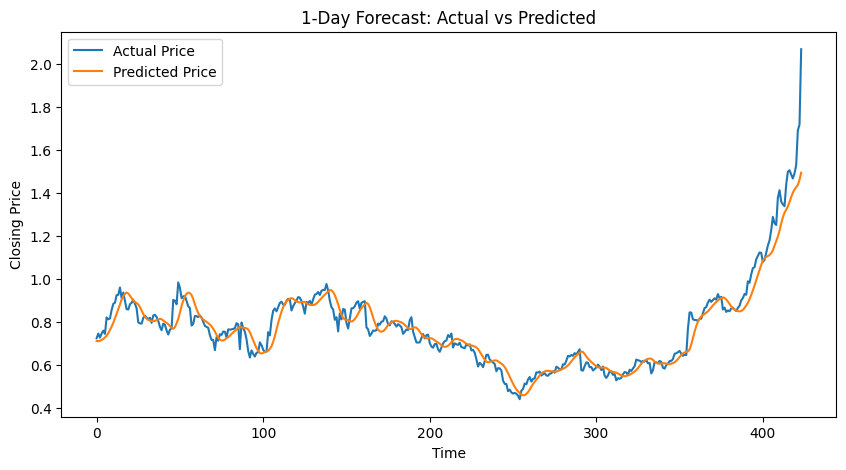

In [10]:
# Step 4: Plot Actual vs Predicted Prices for One-Day
plt.figure(figsize=(10, 5))
plt.plot(actual_1, label='Actual Price')
plt.plot(pred_1, label='Predicted Price')
plt.title('1-Day Forecast: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

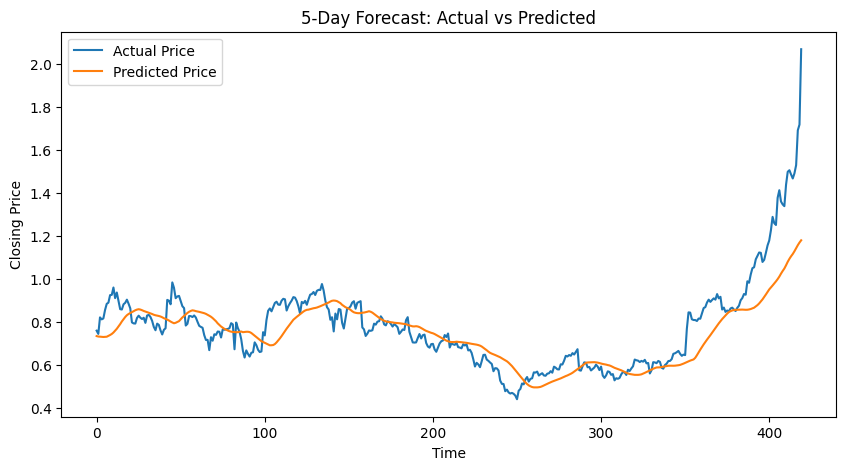

In [11]:
# Step 5: Plot Actual vs Predicted Prices for Five-Days
plt.figure(figsize=(10, 5))
plt.plot(actual_5, label='Actual Price')
plt.plot(pred_5, label='Predicted Price')
plt.title('5-Day Forecast: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

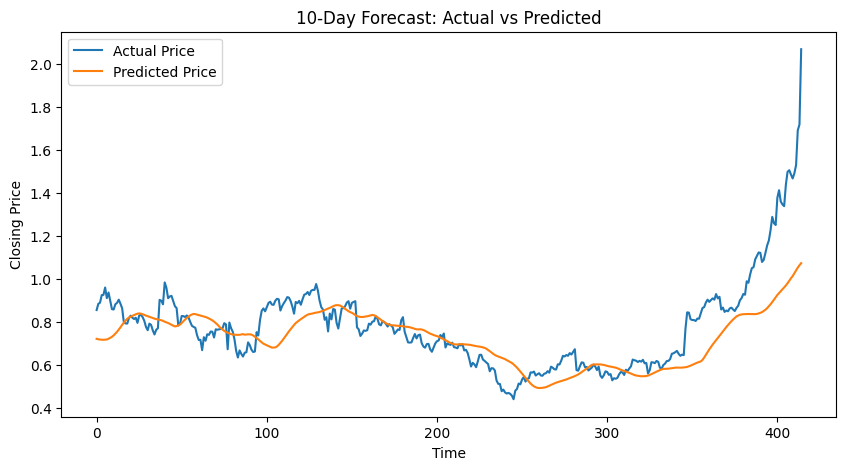

In [12]:
# Step 6: Plot Actual vs Predicted Prices for Ten-Days
plt.figure(figsize=(10, 5))
plt.plot(actual_10, label='Actual Price')
plt.plot(pred_10, label='Predicted Price')
plt.title('10-Day Forecast: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()